In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import warnings
from scipy import stats
import matplotlib.style as style
from scipy.stats import skew
warnings.filterwarnings("ignore")
%matplotlib inline

### 数据读取和展示

In [2]:
price = pd.read_csv('./data/house_price.csv')
price.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### 描述数据

In [3]:
print (f"Train has {price.shape[0]} rows and {price.shape[1]} columns")

Train has 1460 rows and 81 columns


### 绘制数据缺失情况

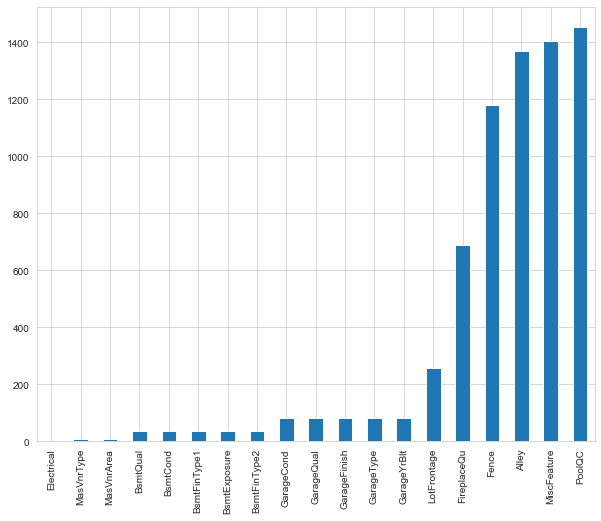

In [4]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)
sns.set_style("whitegrid")
missing = price.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

### 统计缺失比例

In [5]:
def col_miss_percent(data):
    col_miss_percent =(data.isnull().sum()/data.isnull().count()*100).sort_values(ascending=False)
    return col_miss_percent
col_miss_percent(price).head(5)

PoolQC         99.520548
MiscFeature    96.301370
Alley          93.767123
Fence          80.753425
FireplaceQu    47.260274
dtype: float64

### 通过初步观察我们不难发现
#### 1. 数据类型包括数值型和非数值型
#### 2. 一些特征存在缺失值
#### 3. 大部分特征为非数值型数据

### 假设现在我们想关注房价，是否符合正态分布。
#### 注：如果要创建任何线性模型，则必须按正态分布特征。 这是多元线性回归的假设之一。

### 创建房价的直方图，QQ图，和盒图
#### QQ图是一种散点图，对应于正态分布的QQ图，就是由标准正态分布的分位数为横坐标，样本值为纵坐标的散点图（其他版本[2]，有将 (x-m)/std 作为纵坐标，那么正态分布得到的散点图是直线：y=x）。要利用QQ图鉴别样本数据是否近似于正态分布，只需看QQ图上的点是否近似地在一条直线附近，图形是直线说明是正态分布，而且该直线的斜率为标准差，截距为均值，用QQ图还可获得样本偏度和峰度的粗略信息。
#### 注：这里不用纠结每一行代码的具体含义，只要了解一个大概，关键解图像含义，此函数为封装函数，以后碰到类似问题可以直接复制。

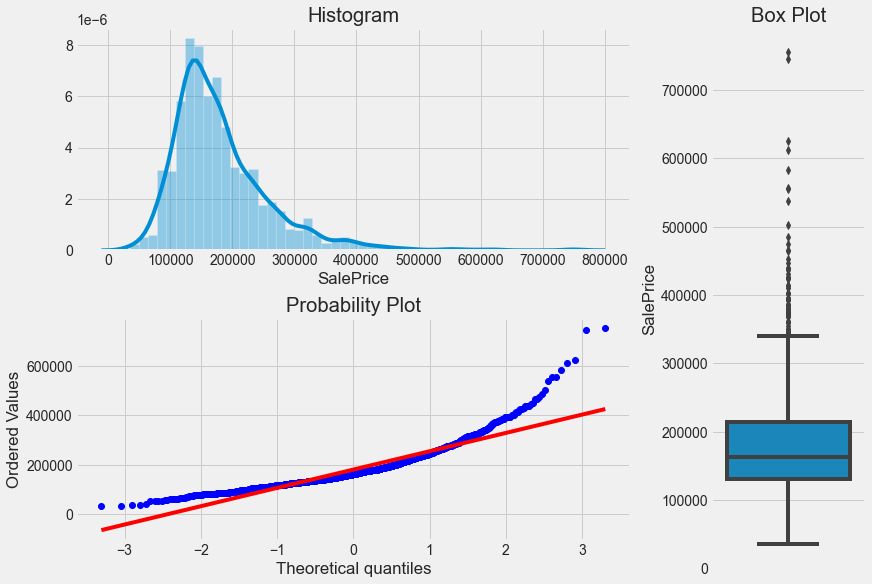

In [6]:
def plotting_3_chart(df, feature):
    style.use('fivethirtyeight')
    #创建自定义图表。
    fig = plt.figure(constrained_layout=True, figsize=(12,8))
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    #创建直方图
    ax1 = fig.add_subplot(grid[0, :2])
    ax1.set_title('Histogram')
    sns.distplot(df.loc[:,feature], norm_hist=True, ax = ax1)

    # 创建QQplot
    ax2 = fig.add_subplot(grid[1, :2]) 
    ax2.set_title('QQ_plot')
    stats.probplot(df.loc[:,feature], plot = ax2)
    
    #创建盒图
    ax3 = fig.add_subplot(grid[:, 2])
    ax3.set_title('Box Plot')
    sns.boxplot(df.loc[:,feature], orient='v', ax = ax3 );
    
plotting_3_chart(price, 'SalePrice')

### 上面的这三个图表可以告诉我们很多有关目标变量的信息。

#### 1.我们的目标变量SalePrice不是正态分布的。
#### 2.我们的目标变量是右偏的。
#### 3.变量中有多个异常值。

### 偏度（Skewness） : 是统计数据分布偏斜方向和程度的度量，是统计数据分布非对称程度的数字特征。
#### 1.对称分布(Symmetrical Distribution) 的偏度将为“ 0”。
#### 2. 偏度有两种类型：正偏度(Positive Skewness)和负偏度(Negative Skewness)。
#### 3.正偏度（类似于我们的目标变量分布）意味着分布右侧的尾巴更长且更胖。
#### 4.在正偏度中，均值和中位数将大于与此数据集相似的众数。 这意味着很多房子以低于平均价格出售
#### 5.负偏度表示分布左侧的尾巴更长且更胖。
#### 6. 在负偏度中，均值和中位数将小于众数。
![title](./image/skewness.jpg)

### 峰度（Kurtosis）：它是分布中存在的极值（异常值）的度量。
#### Mesokurtic：与标准值3的正态曲线相似。这意味着该分布的极值与正态分布的极值相似。峰度为3.
#### Leptokurtic：尖峰，厚尾，峰度>3
#### Platykurtic：其尾部比正态分布更细。 由于此分布的尾部较细，因此与正态分布相比，其离群值更少。
#### 峰度高就意味着方差增大是由低频度的大于或小于平均值的极端差值引起的。
![title](./iamge/kurtosis.jpg)

### 我们可以使用不同类型的转换来解决偏度问题（稍后会详细介绍）。 但是，在此之前，让我们先找出目标变量与其他预测变量之间的关系。 

### 获取特征变量与房价之间的相关性

In [7]:
(price.corr()**2)["SalePrice"].sort_values(ascending = False)[1:].head(10)

OverallQual     0.625652
GrLivArea       0.502149
GarageCars      0.410124
GarageArea      0.388667
TotalBsmtSF     0.376481
1stFlrSF        0.367057
FullBath        0.314344
TotRmsAbvGrd    0.284860
YearBuilt       0.273422
YearRemodAdd    0.257151
Name: SalePrice, dtype: float64

#### 通过降序排序，我们发现房价与OverallQual（总体质量）这个特征相关性最强。
### 通过散点图来观察SalePrice vs OverallQual

In [8]:
def customized_scatterplot(y, x):
    style.use('fivethirtyeight')
    plt.subplots(figsize = (12,8))
    sns.scatterplot(y = y, x = x)

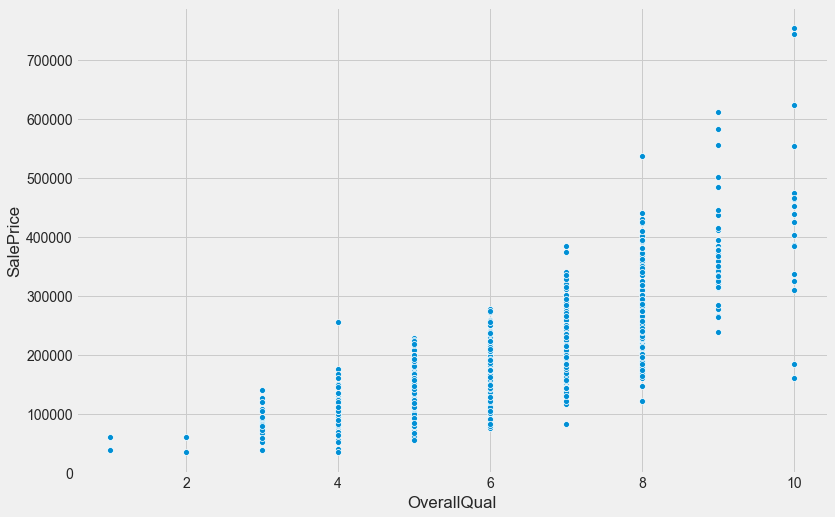

In [9]:
customized_scatterplot(price.SalePrice, price.OverallQual)

#### OverallQual是分类变量，散点图并不是可视化分类变量的最佳方法。 但是，这两个特征之间存在明显的关系。 房屋的价格随着整体质量的提高而增加。 接下来我们查看更多的特征以确定离群值。 这次让我们集中讨论数值变量。

### SalePrice vs GrLivArea(地面居住面积)

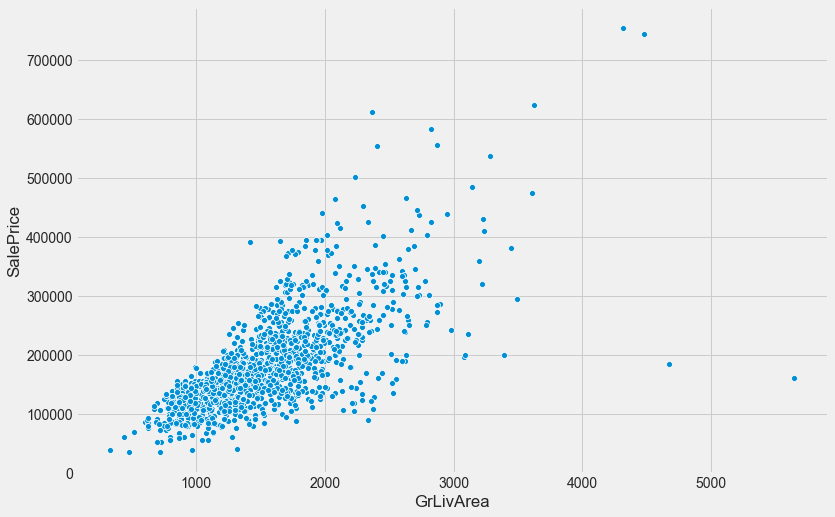

In [10]:
customized_scatterplot(price.SalePrice, price.GrLivArea)

#### 不难看出在图的又下角，有两个异常值，房屋面积很大，价格却很低，我们删除这两个异常点。

In [11]:
price = price[price.GrLivArea < 4500]
price.reset_index(drop = True, inplace = True)

### SalePrice vs GarageArea（车库面积）

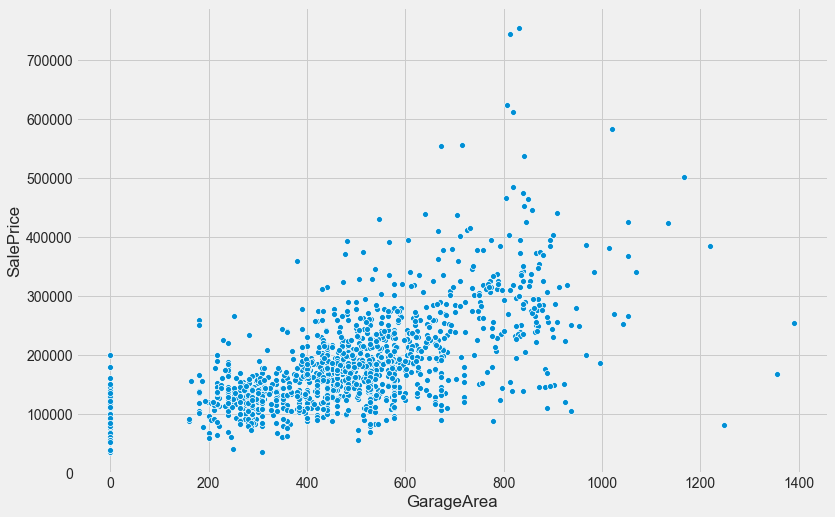

In [12]:
customized_scatterplot(price.SalePrice, price.GarageArea);

### SalePrice vs TotalBsmtSF（地下室面积）

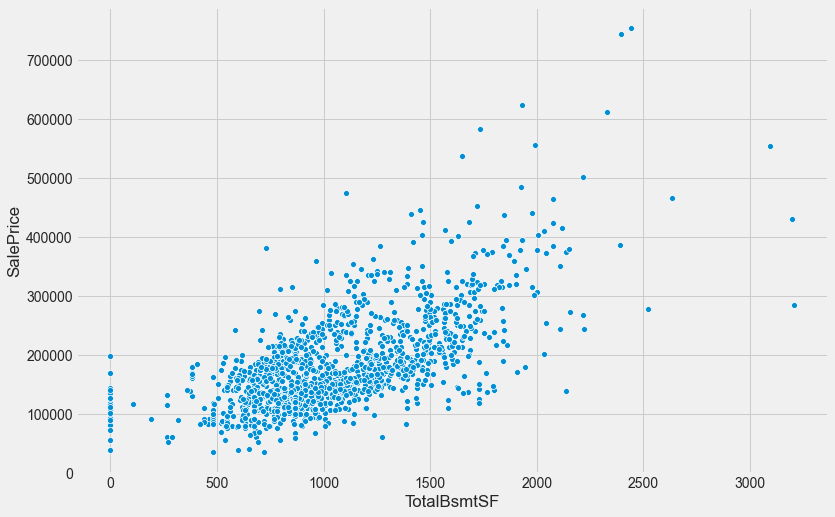

In [13]:
customized_scatterplot(price.SalePrice, price.TotalBsmtSF)

### SalePrice vs 1stFlrSF（第一层面积）

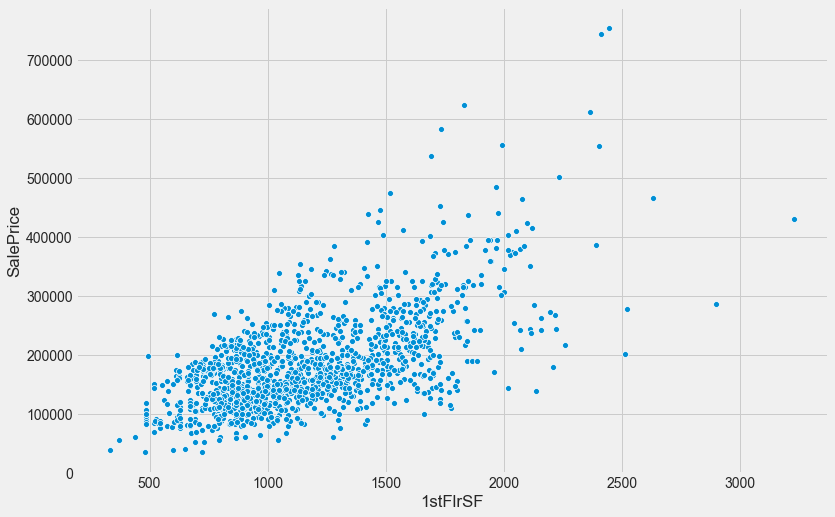

In [14]:
customized_scatterplot(price.SalePrice, price['1stFlrSF']);

### SalePrice vs MasVnrArea（砖石饰面面积）

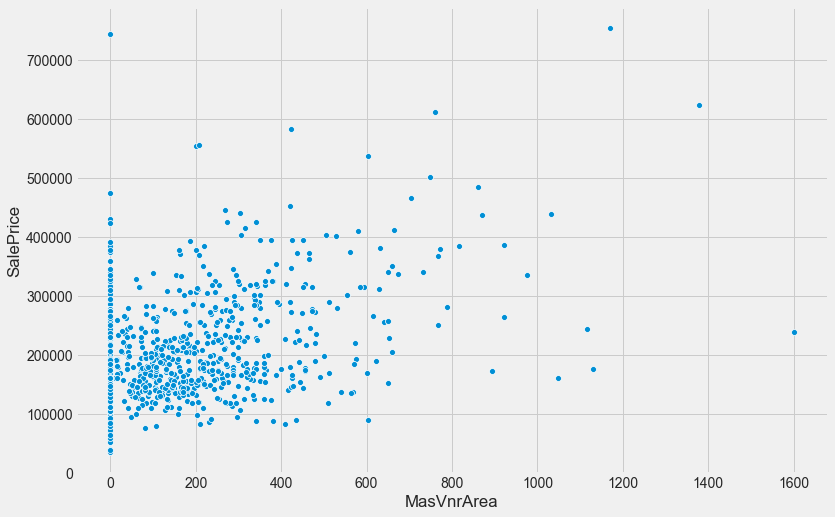

In [15]:
customized_scatterplot(price.SalePrice, price.MasVnrArea);

### 回归的假设
#### 1.线性
#### 2.均方差（恒定误差方差）（vs异方差）。
#### 3. 误差的独立性（与自相关）
#### 4. 多元正态性（误差的正态性）
#### 5.没有或很少有多重共线性。
#### 由于我们拟合线性模型，因此我们假设该关系是线性的，并且误差或残差是围绕真实直线的纯随机波动。我们期望响应变量（因变量）的可变性不会随着预测变量（因变量）的值增加而增加，这是等方差的假设，也称为同方差。我们还假设观测值彼此独立（无多重共线性），并且顺序观测值或自相关之间不存在相关性。

### 那么，我们如何检查回归假设呢？我们拟合一条回归线，然后查看。

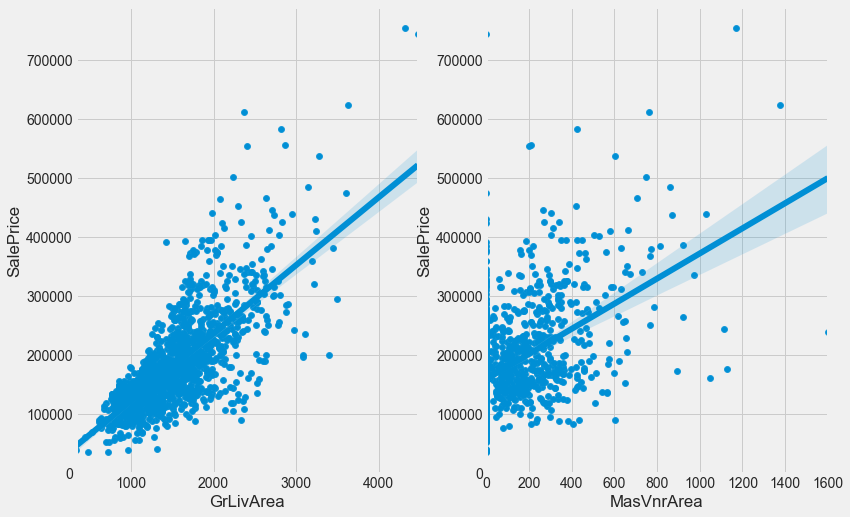

In [16]:
fig, (ax1, ax2) = plt.subplots(figsize = (12,8), ncols=2,sharey=False)
sns.scatterplot( x = price.GrLivArea, y = price.SalePrice,  ax=ax1)
sns.regplot(x=price.GrLivArea, y=price.SalePrice, ax=ax1)

sns.scatterplot(x = price.MasVnrArea,y = price.SalePrice, ax=ax2)
sns.regplot(x=price.MasVnrArea, y=price.SalePrice, ax=ax2);

#### 在这里，我们用两个自变量GrLivArea和MasVnrArea绘制目标变量。从图表中可以明显看出，SalePrice和GrLivArea之间的线性关系要好于SalePrice和MasVnrArea。这里要注意的一件事是，数据集中有一些离群值。由于线性回归对异常影响很敏感，因此必须检查异常值。有时，当数据可能不是线性时，我们可能试图拟合线性回归模型，或者函数可能需要另一个自由度来拟合数据。在这种情况下，我们可能需要根据数据更改功能以获得最佳拟合。除此之外，我们还可以检查残差图，该残差图告诉我们真实线上的误差方差如何。让我们看一下自变量GrLivArea和目标变量SalePrice的残差图。

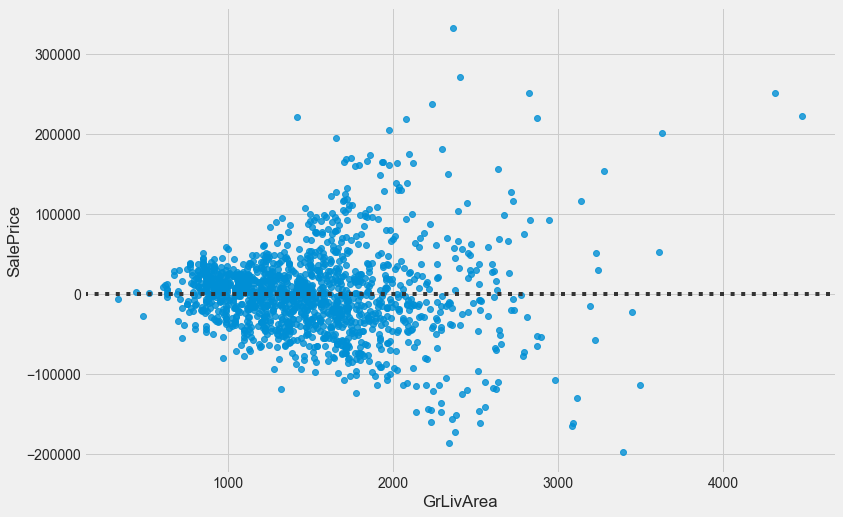

In [17]:
plt.subplots(figsize = (12,8))
sns.residplot(price.GrLivArea, price.SalePrice)

#### 理想情况下，如果满足假设，则残差将随机散布在零的中心线周围，并且没有明显的模式。尽管GrLivArea和SalePrice之间似乎存在线性关系，但残差图看起来更像漏斗。残差图显示，随着GrLivArea值的增加，方差也增加，这就是称为异方差的特征。

#### 均方差（常数方差）：均方差的假设对于线性回归模型至关重要。均方差描述了这样一种情况，其中自变量与因变量之间的关系中的误差项或方差或“噪声”或随机干扰在自变量的所有值上均相同。换句话说，随着预测变量的增加，响应变量中存在恒定的方差。如果像上面的残差图所示，自变量的值之间的“噪声”不同，则我们将其称为异方差。

### 我们已经知道我们的目标变量（SalePrice）不服从正态分布。让我们重新查看之前的3个图。

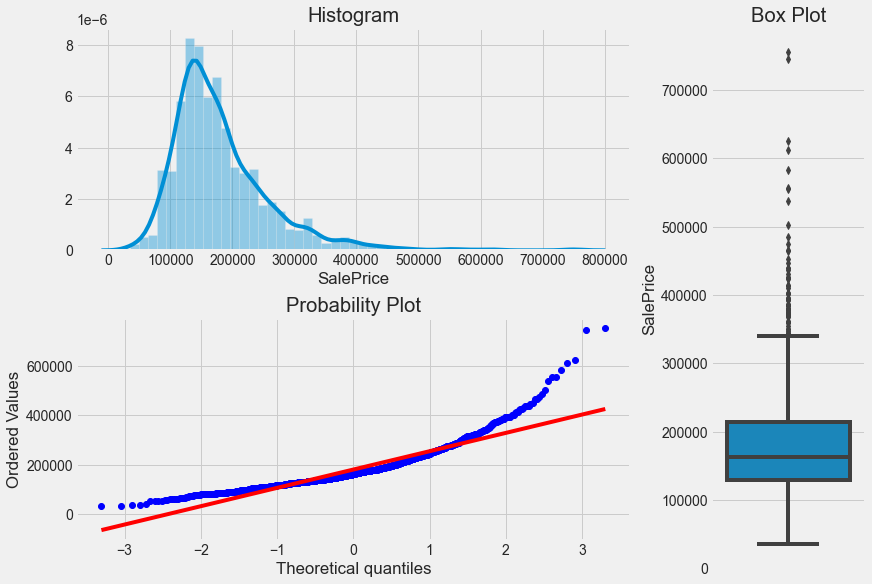

In [18]:
plotting_3_chart(price, 'SalePrice')

### 我们希望我们的目标变量符合正态分布。
### log转换可以帮我们完成该目标。

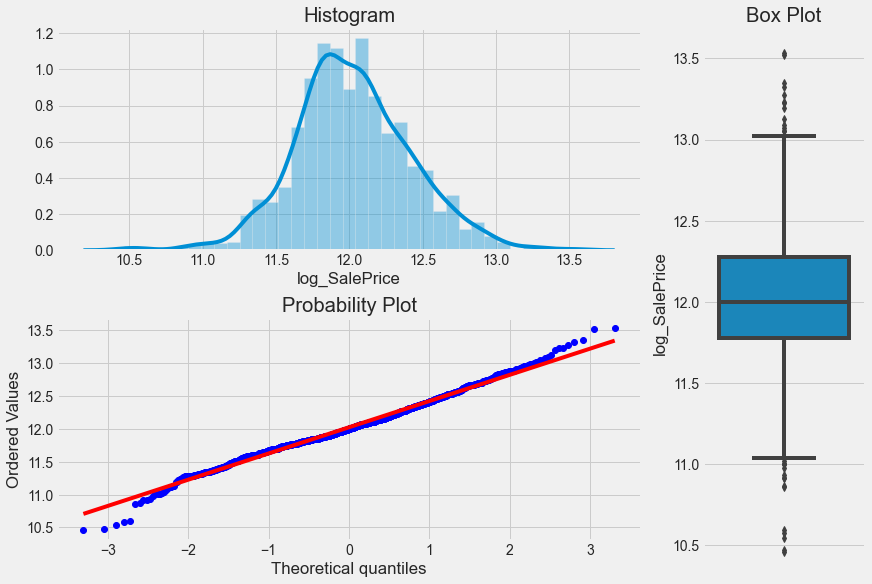

In [19]:
price["log_SalePrice"] = np.log1p(price["SalePrice"])
plotting_3_chart(price, 'log_SalePrice')

#### 可以发现通过log转换，我们的目标变量基本符合了正太分布

### 我们再次对比转换过的目标变量和没转换的目标变量与特征变量（GrLivArea）的残差图。

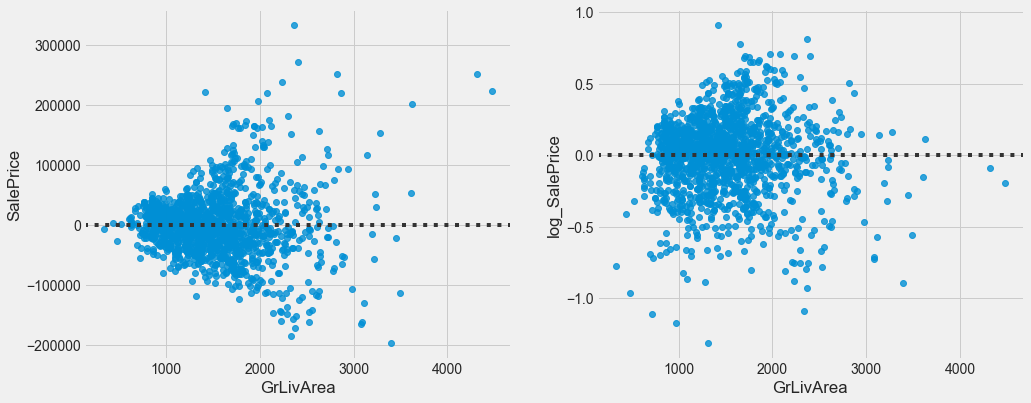

In [20]:
fig, (ax1, ax2) = plt.subplots(figsize = (15,6), 
                               ncols=2, 
                               sharey = False, 
                               sharex=False
                              )
sns.residplot(x = price.GrLivArea, y = price.SalePrice, ax = ax1)
sns.residplot(x = price.GrLivArea, y = price.log_SalePrice, ax = ax2);

#### 我们看到左侧的转换前图表具有异方差性，而右侧的转换后图表具有同方差性（零线之间的方差几乎相等）。

### 多重共线性：多重共线性是指自变量之间具有很强的相关性。线性回归或多线性回归要求自变量具有很少或没有相似特征。多重共线性会导致各种问题。

### 热图是识别是否存在多重共线性的绝佳方法

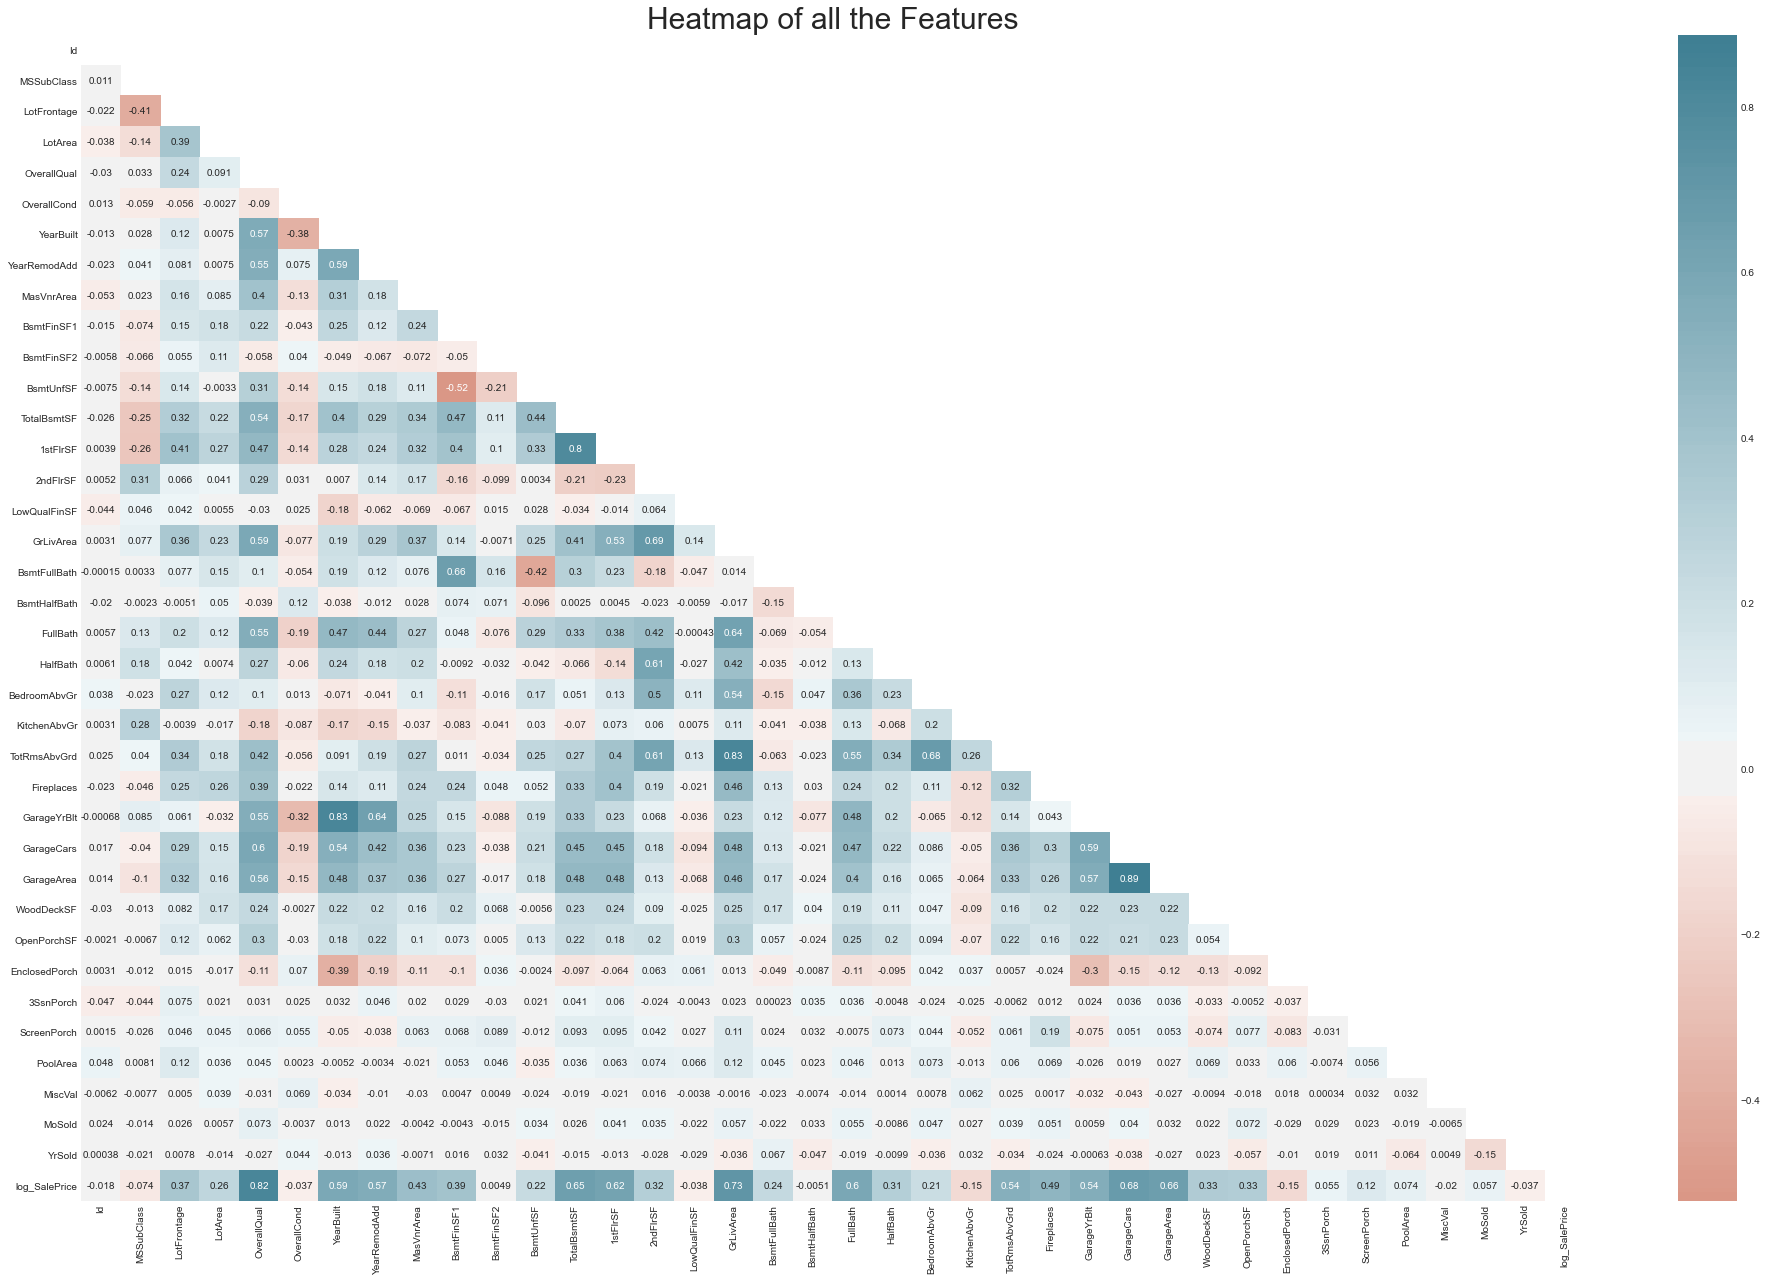

In [21]:
price.drop(columns=['SalePrice'],axis=1,inplace=True)
style.use('ggplot')
sns.set_style('whitegrid')
plt.subplots(figsize = (30,20))
mask = np.zeros_like(price.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(price.corr(), 
            cmap=sns.diverging_palette(20, 220, n=200), 
            mask = mask, 
            annot=True, 
            center = 0, 
           );
plt.title("Heatmap of all the Features", fontsize = 30);

### 如我们所见，多重共线性仍然存在于各种特征中。 但是，为了学习起见，我们暂时保留它们，并让模型（例如，正则化模型，例如Lasso，Ridge）稍后进行清理。 让我们看一下仍然存在的一些相关性。
#### 1.GarageYrBlt和YearBuilt之间有0.83或83％的相关性。
#### 2.TotRmsAbvGrd和GrLivArea之间的相关性为83％。
#### 3.GarageCars和GarageArea之间的相关度为89％。
#### 4.同样，许多其他功能（如BsmtUnfSF，FullBath）与其他独立功能也具有良好的关联性。

### 特征工程

### 处理缺失值

#### 针对数值型数据和非数值型数据分别进行缺失值处理

In [22]:
dig = [f for f in price.columns if price.dtypes[f] != 'object']
dig.remove('log_SalePrice')
dig.remove('Id')
obj = [f for f in price.columns if price.dtypes[f] == 'object']

In [23]:
print(dig)

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


In [24]:
print(obj)

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


In [25]:
missing_dig = (price[dig].isnull().sum()/price[dig].isnull().count()).sort_values(ascending=False)
missing_dig = missing_dig[missing_dig > 0] * 100
print("There are {} dig features with  missing values :".format(missing_dig.shape[0]))
missing_dig = pd.DataFrame({'Percent' :missing_dig})
missing_dig.head()

There are 3 dig features with  missing values :


,Percent
LotFrontage,17.764060
GarageYrBlt,5.555556
MasVnrArea,0.548697


In [26]:
price['LotFrontage'] = price.groupby(['Neighborhood'])['LotFrontage'].apply(lambda x: x.fillna(x.median()))
price['GarageYrBlt'] = price.groupby(['Neighborhood'])['GarageYrBlt'].apply(lambda x: x.fillna(x.median()))
price['MasVnrArea'] = price['MasVnrArea'].fillna(0)

In [27]:
missing_obj = (price[obj].isnull().sum()/price[obj].isnull().count()).sort_values(ascending=False)
missing_obj = missing_obj[missing_obj > 0] * 100
print("There are {} qualitative features with  missing values :".format(missing_obj.shape[0]))
missing_obj = pd.DataFrame({'Percent' :missing_obj})
missing_obj

There are 16 qualitative features with  missing values :


,Percent
PoolQC,99.588477
MiscFeature,96.296296
Alley,93.758573
Fence,80.727023
FireplaceQu,47.325103
GarageCond,5.555556
GarageQual,5.555556
GarageFinish,5.555556
GarageType,5.555556
BsmtFinType2,2.606310


In [28]:
price['MasVnrType'] = price.groupby(['Neighborhood', 'MSSubClass'])['MasVnrType'].apply(lambda x: x.fillna(x.value_counts().index[0]))
for col in ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu','GarageType','GarageFinish',
           'GarageQual','GarageCond','Alley','Fence','PoolQC','MiscFeature']:
    price[col] = price[col].fillna('None')
price['Electrical'] = price.groupby(['Neighborhood','MSSubClass' ])['Electrical'].apply(lambda x: x.fillna(x.value_counts().index[0]))

In [29]:
y = price['log_SalePrice']

In [30]:
price.drop(columns=['Id'],axis=1, inplace=True)
price.drop(columns=['log_SalePrice'],axis=1, inplace=True)

### 偏差修正

In [33]:
numeric_feats = price.dtypes[price.dtypes != "object"].index

skewed_feats = price[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)

skewed_feats

MiscVal          24.434913
PoolArea         15.932532
LotArea          12.560986
3SsnPorch        10.286510
LowQualFinSF      8.995688
KitchenAbvGr      4.480268
BsmtFinSF2        4.247550
ScreenPorch       4.114690
BsmtHalfBath      4.095895
EnclosedPorch     3.083987
MasVnrArea        2.693554
OpenPorchSF       2.337421
LotFrontage       1.546624
WoodDeckSF        1.544214
MSSubClass        1.405563
GrLivArea         1.009951
BsmtUnfSF         0.919955
1stFlrSF          0.886723
2ndFlrSF          0.812121
BsmtFinSF1        0.764002
OverallCond       0.690324
HalfBath          0.679351
TotRmsAbvGrd      0.659822
Fireplaces        0.631409
BsmtFullBath      0.589751
TotalBsmtSF       0.511177
MoSold            0.215211
BedroomAbvGr      0.212107
OverallQual       0.200579
GarageArea        0.131612
YrSold            0.095322
FullBath          0.031239
GarageCars       -0.342025
YearRemodAdd     -0.501322
GarageYrBlt      -0.537831
YearBuilt        -0.611665
dtype: float64

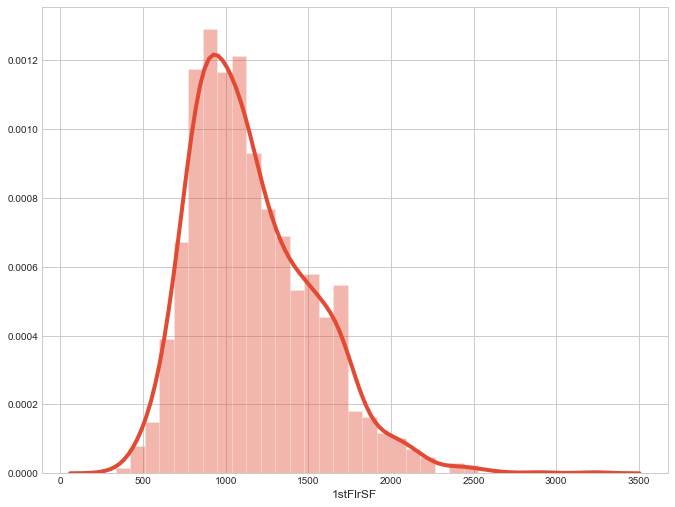

In [34]:
sns.distplot(price['1stFlrSF'])

### 可以看出明显为正偏度，我们希望我们的数据越接近正态分布越好。

### 我们通过Box cox Transformation可以将非正态分布的独立因变量转换成正态分布

In [35]:
def fixing_skewness(df):
    from scipy.stats import skew
    from scipy.special import boxcox1p
    from scipy.stats import boxcox_normmax
    numeric_feats = df.dtypes[df.dtypes != "object"].index
    skewed_feats = df[numeric_feats].apply(lambda x: skew(x)).sort_values(ascending=False)
    high_skew = skewed_feats[abs(skewed_feats) > 0.5]
    skewed_features = high_skew.index
    for feat in skewed_features:
        df[feat] = boxcox1p(df[feat], boxcox_normmax(df[feat] + 1))

fixing_skewness(price)

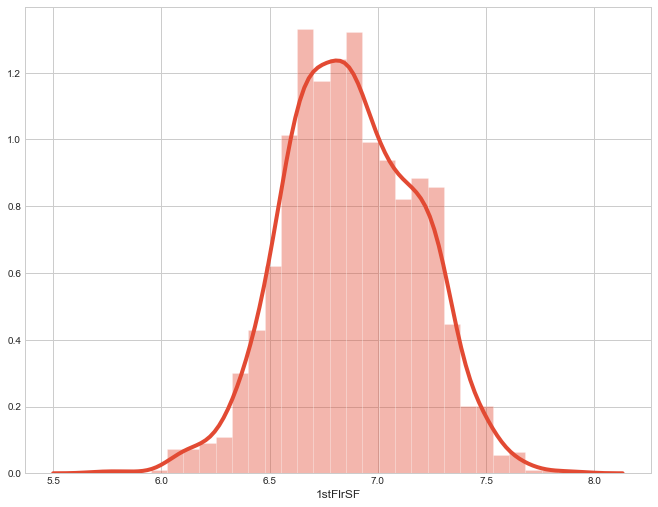

In [36]:
sns.distplot(price['1stFlrSF'])

#### 经过修正后，数据呈现正态分布

### 离散特征编码，因为计算机只能读懂数值型数据，所以我们通过离散特征编码，把object型特征转换成数值编码。

In [37]:
final_features = pd.get_dummies(price).reset_index(drop=True)
final_features.shape

(1458, 301)

### 建立模型，模型在这里不做重点，我们会在机器学习章节中，重点介绍，旨在给大家了解一个建模的流程。

#### 划分数据集和测试集。

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_features, y,test_size = 0.3, random_state = 0)

In [39]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import  cross_val_score

#### 我们使用Ridge 岭回归建模

In [40]:
def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train, scoring = "neg_mean_squared_error", cv = 5))
    return(rmse)

#### 这里使用均方根误差 作为评判标准，越小越好。

In [41]:
ridge = Ridge(alpha = 14)
cv_ridge = rmse_cv(ridge)
ridge.fit(X_train , y_train)
print('Ridge CV score min: ' + str(cv_ridge.min()) + ' mean: ' + str(cv_ridge.mean()) 
      + ' max: ' + str(cv_ridge.max()) )

ValueError: array must not contain infs or NaNs

In [ ]:
from sklearn.metrics import r2_score

#### 这里我们使用r2_score 作为模型评估的标准
#### R2_score = 1，样本中预测值和真实值完全相等，没有任何误差，表示回归分析中自变量对因变量的解释越好。
#### R2_score = 0。此时分子等于分母，样本的每项预测值都等于均值。
#### R2_score不是r的平方，也可能为负数(分子>分母)，模型等于盲猜，还不如直接计算目标变量的平均值。

In [ ]:
y_pred = ridge.predict(X_train)
r2_score(y_train,y_pred)

#### 通过rmse和r2_score 发现我们的模型效果不错，此时我们在预测集里看一下效果。

In [ ]:
y_test_pred = ridge.predict(X_test)
r2_score(y_test,y_test_pred)

#### 预测集的效果也很好，说明我们这里的模型效果可以达到不错的房价预测的效果。